In [206]:
import numpy as np
import random
import string
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F


In [207]:
def generate_orthogonal_vectors(n):
    random_vectors = np.random.rand(n, n)
    orthogonal_vectors, _ = np.linalg.qr(random_vectors)
    return orthogonal_vectors

In [208]:
v = generate_orthogonal_vectors(3)

In [209]:
def generate_sequences(n, T, k):
    assert 1 <= k <= 26, "k doit être entre 1 et 26"
    alphabet = list(string.ascii_uppercase[:k])
    sequences = [random.choices(alphabet, k=T) for _ in range(n)]
    return sequences


In [210]:
def generate_dictionnary(k, empty_token='*'):
    assert 1 <= k <= 26, "k doit être entre 1 et 26"
    
    # Lettres + symbole spécial
    letters = list(string.ascii_uppercase[:k]) + [empty_token]
    d = k + 1  # Dimension de l'espace
    
    # Générer une base orthonormée de dimension (k+1)
    random_matrix = np.random.rand(d, d)
    orthogonal_basis, _ = np.linalg.qr(random_matrix)
    
    # Dictionnaires
    char_to_emb = {char: vec for char, vec in zip(letters, orthogonal_basis)}
    emb_to_char = {tuple(np.round(vec, 8)): char for char, vec in zip(letters, orthogonal_basis)}
    
    return char_to_emb, emb_to_char

In [211]:
def compress_and_pad_left(sequence, empty_token='*'):
    if not sequence:
        return []

    # Supprimer les redondances consécutives
    compressed = [sequence[0]]
    for c in sequence[1:]:
        if c != compressed[-1]:
            compressed.append(c)

    # Ajout des tokens vides au début
    padding_length = len(sequence) - len(compressed)
    padded = [empty_token] * padding_length + compressed
    return padded


In [212]:
def generate_dataset(n, T, k, empty_token='*'):
    char_to_emb, emb_to_char = generate_dictionnary(k)
    alphabet = [c for c in char_to_emb if c != empty_token]
    emb_dim = len(next(iter(char_to_emb.values())))
    
    X_list = []
    y_list = []

    for _ in range(n):
        seq = random.choices(alphabet, k=T)
        emb_seq = [char_to_emb[c] for c in seq]
        
        compressed_seq = compress_and_pad_left(seq, empty_token)
        target_emb_seq = [char_to_emb[c] for c in compressed_seq]

        X_list.append(emb_seq)
        y_list.append(target_emb_seq)

    # Convertir en tensors (facultatif selon ton usage)
    X_tensor = torch.tensor(X_list, dtype=torch.float32)
    y_tensor = torch.tensor(y_list, dtype=torch.float32)

    return X_tensor, y_tensor, char_to_emb, emb_to_char

In [314]:
X, y, char_to_emb, emb_to_char = generate_dataset(20000, 10, 5)

In [315]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [262]:
X_train[1], y_train[1]

(tensor([[-0.5195,  0.8267, -0.2161],
         [-0.4840, -0.4931, -0.7229],
         [-0.4840, -0.4931, -0.7229]]),
 tensor([[-0.7042, -0.2709,  0.6563],
         [-0.5195,  0.8267, -0.2161],
         [-0.4840, -0.4931, -0.7229]]))

In [316]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=300, shuffle=True)
test_loader = DataLoader(test_dataset)

In [264]:
class CustomAttentionOnlyBlock(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.Wq = nn.Linear(embed_dim, embed_dim, bias=False)  # Wq = Wk
        self.Wk = nn.Linear(embed_dim, embed_dim, bias=False)
        self.Wv = nn.Linear(embed_dim, embed_dim, bias=False)
        self.att_weights = None
    def forward(self, x):
        # V = x (identité)
        V = self.Wv(x)
        Q = self.Wq(x)
        K = self.Wk(x)

        # Attention scores : [B, T, T]
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (Q.size(-1) ** 0.5)
        attn_weights = torch.softmax(scores, dim=-1)
        self.att_weights = attn_weights.detach().cpu().numpy()

        # Attention output : [B, T, D]
        attn_output = torch.matmul(attn_weights, V)

        # Résidu
        return x + attn_output


In [265]:
class FinalDAProjection(nn.Module):
    def __init__(self, dim, activation='sigmoid'):
        super().__init__()
        self.Wq = nn.Linear(dim, dim, bias=False)
        self.Wk = nn.Linear(dim, dim, bias=False)
        self.V = nn.Linear(dim, dim, bias=False)
        self.att_weights = None


    def forward(self, x):
        # x : [B, T, D]
        Q = self.Wq(x)                    
        K = self.Wk(x)
        V = self.V(x)
        # Attention scores : [B, T, T]
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (Q.size(-1) ** 0.5)
        attn_output = torch.softmax(scores, dim=-1)
        self.att_weights = attn_output.detach().cpu().numpy()
        output = torch.matmul(attn_output, V)
        return output

In [266]:
class CustomTransformerAttentionOnly(nn.Module):
    def __init__(self, embed_dim, num_layers=2):
        super().__init__()
        layers = [CustomAttentionOnlyBlock(embed_dim) for _ in range(num_layers - 1)]
        layers.append(FinalDAProjection(embed_dim))  # <-- ajout ici
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x  # [B, T] (si FinalDAProjection retourne un score par token)


In [267]:
loss_fn = nn.MSELoss()

In [268]:
def train_model(model, train_loader, test_loader, epochs=10, lr=1e-3, device='cpu'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        model.eval()
        with torch.no_grad():
            total_val_loss = 0
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = loss_fn(pred, yb)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(test_loader)
        model.train()
        total_loss = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            pred = model(xb)  # [B, T, D]
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Évaluation

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


In [269]:
model = CustomTransformerAttentionOnly(embed_dim=X_train.shape[-1], num_layers=2)
train_model(model, train_loader, test_loader, epochs=20, lr=0.01)

Epoch 1/20 | Train Loss: 0.2567 | Val Loss: 0.4132
Epoch 2/20 | Train Loss: 0.1780 | Val Loss: 0.1921
Epoch 3/20 | Train Loss: 0.1715 | Val Loss: 0.1722
Epoch 4/20 | Train Loss: 0.1710 | Val Loss: 0.1711
Epoch 5/20 | Train Loss: 0.1708 | Val Loss: 0.1708
Epoch 6/20 | Train Loss: 0.1707 | Val Loss: 0.1706
Epoch 7/20 | Train Loss: 0.1705 | Val Loss: 0.1706
Epoch 8/20 | Train Loss: 0.1706 | Val Loss: 0.1706
Epoch 9/20 | Train Loss: 0.1706 | Val Loss: 0.1704
Epoch 10/20 | Train Loss: 0.1705 | Val Loss: 0.1707
Epoch 11/20 | Train Loss: 0.1706 | Val Loss: 0.1704
Epoch 12/20 | Train Loss: 0.1705 | Val Loss: 0.1705
Epoch 13/20 | Train Loss: 0.1705 | Val Loss: 0.1704
Epoch 14/20 | Train Loss: 0.1705 | Val Loss: 0.1705
Epoch 15/20 | Train Loss: 0.1705 | Val Loss: 0.1704
Epoch 16/20 | Train Loss: 0.1708 | Val Loss: 0.1705
Epoch 17/20 | Train Loss: 0.1706 | Val Loss: 0.1704
Epoch 18/20 | Train Loss: 0.1706 | Val Loss: 0.1703
Epoch 19/20 | Train Loss: 0.1705 | Val Loss: 0.1705
Epoch 20/20 | Train L

In [289]:
def evaluate_on_sequence(model, seq, char_to_emb, emb_to_char, empty_token='*', device='cpu'):
    model.eval()
    
    # 1. Encoder la séquence d'entrée
    emb_seq = [char_to_emb[c] for c in seq]

    x = torch.tensor(emb_seq, dtype=torch.float32).unsqueeze(0).to(device)  # [1, T, D]

    # 2. Prédiction
    with torch.no_grad():
        pred = model(x)[0]  # [T, D]
    

    # 3. Décoder la sortie
    def closest_embedding(vec):
        return min(emb_to_char.items(), key=lambda kv: np.linalg.norm(vec - np.array(kv[0])))[1]

    decoded_pred = [closest_embedding(p.cpu().numpy()) for p in pred]

    # 4. Cible attendue (compress + pad)
    target_seq = compress_and_pad_left(seq, empty_token)

    # 5. Affichage
    print("Séquence d’entrée      :", seq)
    print("Séquence compressée     :", target_seq)
    print("Séquence prédite (model):", decoded_pred)


In [275]:
import matplotlib.pyplot as plt
import seaborn as sns

def show_attention_maps(model, input_sequence, char_to_emb, layer_names=None):
    model.eval()
    seq_len = len(input_sequence)
    emb_seq = [char_to_emb[c] for c in input_sequence]
    x = torch.tensor(emb_seq, dtype=torch.float32).unsqueeze(0)  # [1, T, D]
    
    # Run forward to populate attn_weights
    with torch.no_grad():
        model(x)

    # Afficher les matrices d'attention de chaque couche
    for i, layer in enumerate(model.layers):
        print(i)
        attn = layer.att_weights[0]  # [T, T]
        plt.figure(figsize=(6, 5))
        sns.heatmap(attn, annot=True, fmt=".2f", cmap="Blues", cbar=True)
        title = layer_names[i] if layer_names else f"Attention Layer {i+1}"
        plt.title(title)
        plt.xlabel("Key position")
        plt.ylabel("Query position")
        plt.show()


0


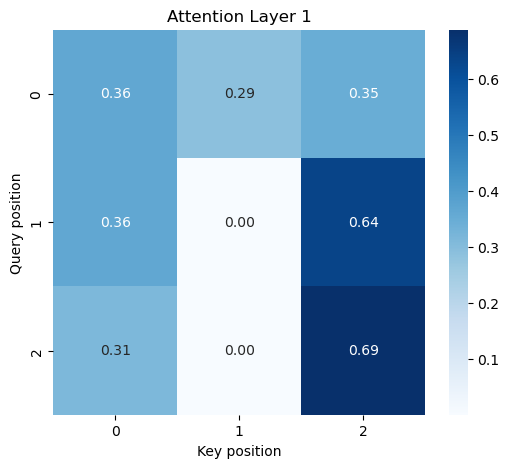

1


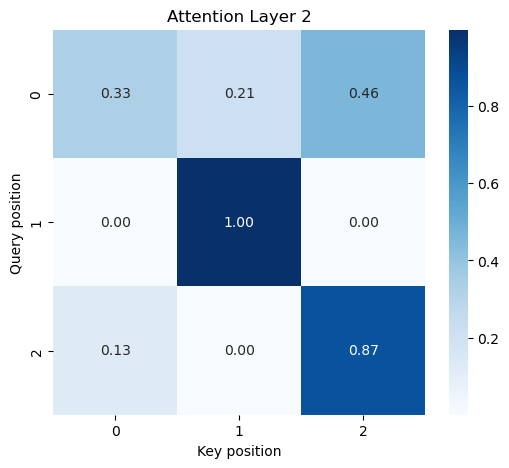

In [282]:
sequence = ['A', 'B', 'A']
show_attention_maps(model, sequence, char_to_emb)

In [281]:
# Exemple : test sur une séquence simple
sequences = [['A','B', 'B']]

for sequence in sequences:
    print("\nSéquence d'entrée :", sequence)
    evaluate_on_sequence(model, sequence, char_to_emb, emb_to_char, empty_token='*')



Séquence d'entrée : ['*', 'B', 'B']
emb_seq [array([-0.7041772 , -0.27090326,  0.65631235]), array([-0.48404207, -0.4931019 , -0.72287882]), array([-0.48404207, -0.4931019 , -0.72287882])]
Prédiction brute (embeddings) : tensor([[ 0.1971, -0.3666,  0.4056],
        [-0.0512, -0.6308,  0.2465],
        [-0.0512, -0.6308,  0.2465]])
Séquence d’entrée      : ['*', 'B', 'B']
Séquence compressée     : ['*', '*', 'B']
Séquence prédite (model): ['*', '*', '*']


In [324]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=4, dim_feedforward=512, dropout=0.1, max_len=512):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(d_model, input_dim)

    def forward(self, src):
        x = self.input_proj(src)  # [B, T, D_model]
        x = self.transformer_encoder(x)
        out = self.output_proj(x)  # [B, T, D_input] (embedding)
        return out


In [325]:
def train_model(model, train_loader, test_loader, epochs=10, lr=1e-3, device='cpu'):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(1, epochs + 1):
        model.train()
        total_train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = loss_fn(pred, yb)
                total_val_loss += loss.item()

        print(f"Epoch {epoch}/{epochs} | Train Loss: {total_train_loss/len(train_loader):.4f} | Val Loss: {total_val_loss/len(test_loader):.4f}")


In [320]:
embedding_dim = X_train.shape[-1]

In [326]:
model = TransformerModel(input_dim=embedding_dim)
train_model(model, train_loader, test_loader, epochs=10, lr=1e-3)


Epoch 1/10 | Train Loss: 0.1921 | Val Loss: 0.1210
Epoch 2/10 | Train Loss: 0.1263 | Val Loss: 0.1191
Epoch 3/10 | Train Loss: 0.1226 | Val Loss: 0.1189
Epoch 4/10 | Train Loss: 0.1205 | Val Loss: 0.1184
Epoch 5/10 | Train Loss: 0.1193 | Val Loss: 0.1180
Epoch 6/10 | Train Loss: 0.1185 | Val Loss: 0.1180
Epoch 7/10 | Train Loss: 0.1180 | Val Loss: 0.1178
Epoch 8/10 | Train Loss: 0.1176 | Val Loss: 0.1177
Epoch 9/10 | Train Loss: 0.1175 | Val Loss: 0.1175
Epoch 10/10 | Train Loss: 0.1172 | Val Loss: 0.1175


In [327]:
# generate sequences
sequences = generate_sequences(5, 10, 5)


for sequence in sequences:
    print('___________________________')
    evaluate_on_sequence(model, sequence, char_to_emb, emb_to_char, empty_token='*')

___________________________
Séquence d’entrée      : ['E', 'C', 'E', 'B', 'A', 'D', 'B', 'D', 'B', 'A']
Séquence compressée     : ['E', 'C', 'E', 'B', 'A', 'D', 'B', 'D', 'B', 'A']
Séquence prédite (model): ['E', 'C', 'E', 'B', 'A', 'D', 'B', 'D', 'B', 'A']
___________________________
Séquence d’entrée      : ['B', 'A', 'B', 'A', 'E', 'D', 'D', 'C', 'C', 'C']
Séquence compressée     : ['*', '*', '*', 'B', 'A', 'B', 'A', 'E', 'D', 'C']
Séquence prédite (model): ['B', 'A', 'B', 'A', 'E', 'D', 'D', 'C', 'C', 'C']
___________________________
Séquence d’entrée      : ['C', 'A', 'E', 'A', 'D', 'E', 'A', 'C', 'D', 'B']
Séquence compressée     : ['C', 'A', 'E', 'A', 'D', 'E', 'A', 'C', 'D', 'B']
Séquence prédite (model): ['C', 'A', 'E', 'A', 'D', 'E', 'A', 'C', 'D', 'B']
___________________________
Séquence d’entrée      : ['E', 'A', 'D', 'C', 'E', 'B', 'D', 'D', 'E', 'B']
Séquence compressée     : ['*', 'E', 'A', 'D', 'C', 'E', 'B', 'D', 'E', 'B']
Séquence prédite (model): ['E', 'A', 'D', 'C'